# Predicting Newsletter Sign-Up From Firstweek Playtime on a Minecraft Research Server
*Allan Xue – DSCI 100 Final Project – June 2025*

### Introduction

#### Background

A research group in the UBC Computer Science department, led by Frank Wood, is operating a public Minecraft server to investigate how people explore, build, and cooperate in an open-world game. Due to the nature of the project, the team must recruit and retain players, ensuring they have sufficient resources to manage the large number of players. One early signal of engagement is whether a newcomer decides to enroll in the project newsletter. If we can predict the choice based on the behaviour shown in the first few days, the team can automate follow-up emails and avoid wasting resources on unlikely contributors. 

#### Question
Can a player's total playtime in their first seven days on the server predict whether they will subscribe to the newsletter?

#### Data Description


| File | Rows | Cols | One row = | Key variables (type) | Notes |
|------|------|------|-----------|----------------------|-------|
| **`players.csv`** | **196** | 7 | an individual player | `hashedEmail` (str, unique ID)  <br>`experience` (chr – “Amateur”, “Regular”, …)  <br>`played_hours` (num – lifetime hours when file exported)  <br>`gender` (chr)  <br>`Age` (num)  <br>`subscribe` (lgl) | 2 missing `Age` values; 144 subscribers vs 52 non-subscribers |
| **`sessions.csv`** | **1535** | 5 | one login session | `hashedEmail` (str, FK → players)  <br>`start_time`, `end_time` (chr “dd/mm/YYYY HH:MM”)  <br>`original_start_time`, `original_end_time` (num – Unix ms) | 2 sessions have missing `end_time` (player disconnected abruptly) |


#### Collected variables

* **`hashedEmail`** – identifies a participant while preserving anonymity.  
* **`experience`** – self-reported Minecraft skill tier at sign-up (`Amateur`, `Regular`, `Pro`, `Veteran`, `Legend`).  
* **`played_hours`** – hours played before the current data pull
* **Session times**    
  * `start_time`/`end_time`: human-readable; converted to calendar time during wrangling.  
  * `original_start_time/end_time`: kept as reference.



#### Considerations
* **Missing values:** 2 ages, 2 session `end_time`s. We put `total_minutes_first_week = 0` when a player has no sessions in week 1.  
* **Potential bias:** Players choose to sign up, so the sample may over-represent highly motivated individuals.  
* **Time stamps:** Stored as strings and must be parsed carefully
* **Unit mismatch:** `played_hours` is hours, but predictor is minutes. We keep both and label units in plots.


### Methods and Results

In [9]:
library(tidyverse)     
library(tidymodels)
library(lubridate)

players  <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
# Computes the first week minutes played

sessions <- sessions |>
  mutate(across(c(start_time, end_time), dmy_hm),
         duration_min = as.numeric(difftime(end_time, start_time, units = "mins")))

first_login <- sessions |>
  group_by(hashedEmail) |>
  summarise(first_start = min(start_time), .groups = "drop")

first_week <- sessions |>
  left_join(first_login, by = "hashedEmail") |>
  mutate(within_week = start_time <= first_start + days(7)) |>
  filter(within_week) |>
  group_by(hashedEmail) |>
  summarise(total_minutes_first_week = sum(duration_min, na.rm = TRUE),
            .groups = "drop")

df <- players |>
  left_join(first_week, by = "hashedEmail") |>
  mutate(total_minutes_first_week = replace_na(total_minutes_first_week, 0),
         subscribe = as_factor(subscribe))

In [11]:
# Numeric Summary of Data

df |> 
  summarise(
    n_players  = n(),
    pct_sub    = mean(as.numeric(subscribe))-1,
    median_min = median(total_minutes_first_week),
    IQR_min    = IQR(total_minutes_first_week)
  )

n_players,pct_sub,median_min,IQR_min
<int>,<dbl>,<dbl>,<dbl>
196,0.7346939,9,35.25


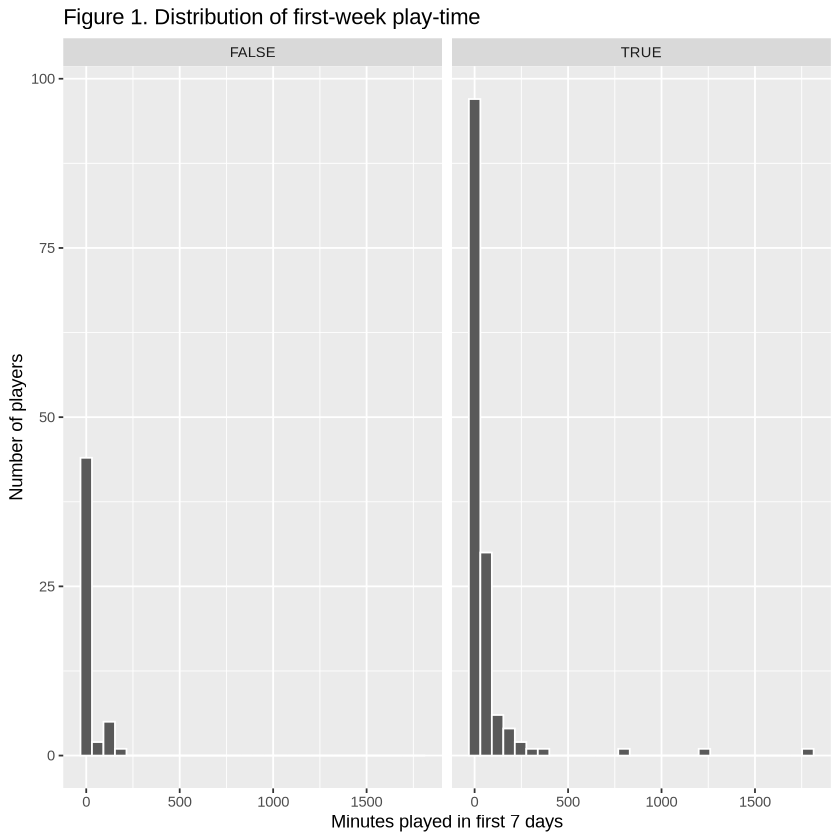

In [13]:
ggplot(df, aes(x = total_minutes_first_week)) +
  geom_histogram(bins = 30, colour = "white") +
  facet_wrap(~ subscribe,
             labeller = labeller(subscribe = c(`0` = "No", `1` = "Yes"))) +
  labs(title = "Figure 1. Distribution of first-week play-time",
       x = "Minutes played in first 7 days",
       y = "Number of players") +
  theme(text = element_text(size = 11))

**Figure 1.**  
Both histograms are right-skewed and overlap strongly.  
Subscribers show a shift toward longer play times the 30 60 min bin is visibly taller but the majority of both groups still fall below one hour, suggesting playtime alone will be a weak predictor of newsletter sign-up.

In [15]:
set.seed(42)
split  <- initial_split(df, prop = 0.7, strata = subscribe)
train  <- training(split)
test   <- testing(split)

# recipe: centre & scale the single predictor 
rec <- recipe(subscribe ~ total_minutes_first_week, data = train) |>
         step_center(all_predictors()) |>
         step_scale(all_predictors())

# KNN specification: k = 5 
knn_spec <- nearest_neighbor(neighbors = 5) |> 
              set_engine("kknn") |>
              set_mode("classification")

wf <- workflow() |>
        add_recipe(rec) |>
        add_model(knn_spec)

knn_fit <- fit(wf, data = train)

pred <- predict(knn_fit, test) |>
          bind_cols(test)

acc <- accuracy(pred, truth = subscribe, estimate = .pred_class)
acc                # prints a tibble with the accuracy value

cm <- conf_mat(pred, truth = subscribe, estimate = .pred_class)
cm     

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4666667


          Truth
Prediction FALSE TRUE
     FALSE     8   24
     TRUE      8   20